In [6]:
from heapq import heappush, heappop
import math
import networkx as nx
import matplotlib.pyplot as plt

In [7]:
class Vertex:
    def __init__(self, id, x, y):
        self.id = id
        self.x = x
        self.y = y
        self.edges = {}  # Dictionary of connected vertices and their edges
    
    def __str__(self):
        return f"Vertex {self.id} at ({self.x}, {self.y})"

class Edge:
    def __init__(self, vertex1, vertex2, weights):
        self.vertex1 = vertex1
        self.vertex2 = vertex2
        self.weights = weights
    
    def get_weight(self, traffic_condition='normal'):
        return self.weights.get(traffic_condition, self.weights['normal'])
    
    def __str__(self):
        return f"Edge {self.vertex1.id}-{self.vertex2.id}: {self.weights}"

class Graph:
    def __init__(self):
        self.vertices = {}
        
    def add_vertex(self, id, x, y):
        vertex = Vertex(id, x, y)
        self.vertices[id] = vertex
        return vertex
    
    def add_edge(self, id1, id2, light_traffic, normal_traffic, rush_hour):
        if id1 not in self.vertices or id2 not in self.vertices:
            raise ValueError("Both vertices must exist in the graph")
        
        weights = {
            'light': light_traffic,
            'normal': normal_traffic,
            'rush_hour': rush_hour
        }
        
        edge = Edge(self.vertices[id1], self.vertices[id2], weights)
        self.vertices[id1].edges[id2] = edge
        self.vertices[id2].edges[id1] = edge
        return edge

    def dijkstra(self, start_id, end_id, traffic_condition='normal'):
        """
        Find shortest path between start_id and end_id using Dijkstra's algorithm
        Returns: (total_time, path)
        """
        if start_id not in self.vertices or end_id not in self.vertices:
            raise ValueError("Both start and end vertices must exist in the graph")

        # Initialize distances and predecessors
        distances = {vertex_id: float('infinity') for vertex_id in self.vertices}
        distances[start_id] = 0
        predecessors = {vertex_id: None for vertex_id in self.vertices}
        
        # Priority queue for vertices to visit
        pq = [(0, start_id)]
        visited = set()
        
        while pq:
            current_distance, current_id = heappop(pq)
            
            if current_id == end_id:
                break
                
            if current_id in visited:
                continue
                
            visited.add(current_id)
            
            # Check all neighbors
            for neighbor_id, edge in self.vertices[current_id].edges.items():
                if neighbor_id in visited:
                    continue
                    
                weight = edge.get_weight(traffic_condition)
                distance = current_distance + weight
                
                if distance < distances[neighbor_id]:
                    distances[neighbor_id] = distance
                    predecessors[neighbor_id] = current_id
                    heappush(pq, (distance, neighbor_id))
        
        # Reconstruct path
        path = []
        current_id = end_id
        while current_id is not None:
            path.append(current_id)
            current_id = predecessors[current_id]
        path.reverse()
        
        return distances[end_id], path

    def get_path_description(self, path, traffic_condition='normal'):
        """Generate a description of the path including directions and times"""
        if not path or len(path) < 2:
            return "Invalid path"
            
        description = []
        total_time = 0
        
        for i in range(len(path) - 1):
            current_id = path[i]
            next_id = path[i + 1]
            current_vertex = self.vertices[current_id]
            next_vertex = self.vertices[next_id]
            edge = current_vertex.edges[next_id]
            time = edge.get_weight(traffic_condition)
            total_time += time
            
            # Calculate direction
            dx = next_vertex.x - current_vertex.x
            dy = next_vertex.y - current_vertex.y
            direction = self._get_direction(dx, dy)
            
            description.append(f"From vertex {current_id} go {direction} to vertex {next_id} ({time} minutes)")
        
        description.append(f"\nTotal time: {total_time} minutes")
        return "\n".join(description)

    def _get_direction(self, dx, dy):
        """Helper function to determine cardinal direction"""
        angle = math.degrees(math.atan2(dy, dx))
        if -22.5 <= angle <= 22.5:
            return "east"
        elif 22.5 < angle <= 67.5:
            return "northeast"
        elif 67.5 < angle <= 112.5:
            return "north"
        elif 112.5 < angle <= 157.5:
            return "northwest"
        elif angle > 157.5 or angle <= -157.5:
            return "west"
        elif -157.5 < angle <= -112.5:
            return "southwest"
        elif -112.5 < angle <= -67.5:
            return "south"
        else:
            return "southeast"

def visualize_graph(graph, path=None, traffic_condition='normal'):
    """
    Visualize the graph using networkx and matplotlib.
    Optional path highlighting for showing routes.
    """
    # Create a NetworkX graph
    G = nx.Graph()
    
    # Add nodes with positions
    pos = {}
    node_colors = []
    for vertex_id, vertex in graph.vertices.items():
        G.add_node(vertex_id)
        pos[vertex_id] = (vertex.x, vertex.y)
        
        # Color nodes based on their type
        if vertex_id <= 5:  # Downtown Core
            node_colors.append('#FF9999')  # Soft red for downtown
        elif vertex_id <= 13:  # Inner Residential 
            node_colors.append('#99FF99')  # Soft green for inner residential
        elif vertex_id <= 21:  # Outer Residential
            node_colors.append('#FFFF99')  # Soft yellow for outer residential
        else:  # Commercial/Industrial
            node_colors.append('#9999FF')  # Soft blue for commercial
    
    # Add edges
    edges = []
    edge_weights = []
    for v_id, vertex in graph.vertices.items():
        for neighbor_id, edge in vertex.edges.items():
            if (neighbor_id, v_id) not in edges:  # Avoid duplicate edges
                edges.append((v_id, neighbor_id))
                edge_weights.append(edge.get_weight(traffic_condition))
    
    G.add_edges_from(edges)
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    
    # Draw the edges
    nx.draw_networkx_edges(G, pos, edge_color='gray', width=1)
    
    # If there's a path, highlight it
    if path and len(path) > 1:
        path_edges = list(zip(path[:-1], path[1:]))
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, 
                             edge_color='red', width=2)
    
    # Draw the nodes
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, 
                          node_size=700, alpha=0.8)
    
    # Add node labels
    nx.draw_networkx_labels(G, pos, font_size=10)
    
    # Add edge labels (weights)
    edge_labels = {(u, v): w for (u, v), w in zip(edges, edge_weights)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=8)
    
    # Add legend with enhanced colors
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                 markerfacecolor='#FF9999', markersize=10, 
                                 label='Downtown Core'),
                      plt.Line2D([0], [0], marker='o', color='w', 
                                 markerfacecolor='#99FF99', markersize=10, 
                                 label='Inner Residential'),
                      plt.Line2D([0], [0], marker='o', color='w', 
                                 markerfacecolor='#FFFF99', markersize=10, 
                                 label='Outer Residential'),
                      plt.Line2D([0], [0], marker='o', color='w', 
                                 markerfacecolor='#9999FF', markersize=10, 
                                 label='Commercial/Industrial')]
    
    if path:
        legend_elements.append(plt.Line2D([0], [0], color='red', 
                                        label='Selected Path'))
    
    plt.legend(handles=legend_elements, loc='upper right')
    
    # Add title with traffic condition
    plt.title(f'Map Visualization ({traffic_condition} traffic)')
    plt.axis('equal')  # Equal aspect ratio
    plt.show()


Showing basic map:


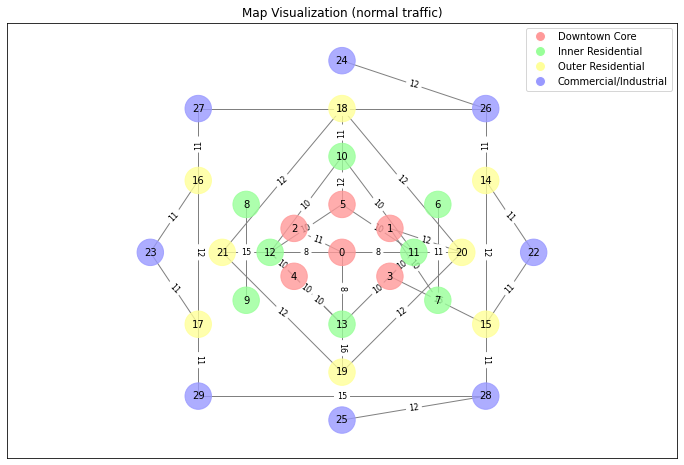

In [8]:
def create_map():
    """Create complex map with additional connections"""
    graph = Graph()
    
    # Add all vertices (same as original)
    # Downtown Core (0-5)
    graph.add_vertex(0, 0, 0)       # Central Plaza
    graph.add_vertex(1, 2, 1)       # Financial District
    graph.add_vertex(2, -2, 1)      # Government Center
    graph.add_vertex(3, 2, -1)      # Shopping District
    graph.add_vertex(4, -2, -1)     # Entertainment District
    graph.add_vertex(5, 0, 2)       # Business Park
    
    # Inner Residential (6-13)
    graph.add_vertex(6, 4, 2)       # North Heights
    graph.add_vertex(7, 4, -2)      # East Gardens
    graph.add_vertex(8, -4, 2)      # West Hills
    graph.add_vertex(9, -4, -2)     # South Vale
    graph.add_vertex(10, 0, 4)      # University District
    graph.add_vertex(11, 3, 0)      # Central Heights
    graph.add_vertex(12, -3, 0)     # Central Valley
    graph.add_vertex(13, 0, -3)     # Lake District
    
    # Outer Residential (14-21)
    graph.add_vertex(14, 6, 3)      # Far North Heights
    graph.add_vertex(15, 6, -3)     # Far East Gardens
    graph.add_vertex(16, -6, 3)     # Far West Hills
    graph.add_vertex(17, -6, -3)    # Far South Vale
    graph.add_vertex(18, 0, 6)      # North End
    graph.add_vertex(19, 0, -5)     # South End
    graph.add_vertex(20, 5, 0)      # East End
    graph.add_vertex(21, -5, 0)     # West End
    
    # Commercial/Industrial Areas (22-29)
    graph.add_vertex(22, 8, 0)      # East Industrial Park
    graph.add_vertex(23, -8, 0)     # West Industrial Park
    graph.add_vertex(24, 0, 8)      # North Mall
    graph.add_vertex(25, 0, -7)     # South Mall
    graph.add_vertex(26, 6, 6)      # Northeast Shopping Center
    graph.add_vertex(27, -6, 6)     # Northwest Shopping Center
    graph.add_vertex(28, 6, -6)     # Southeast Shopping Center
    graph.add_vertex(29, -6, -6)    # Southwest Shopping Center

    # Add all original edges first
    # [All the original edge definitions from create_complex_map()]
    
    # Add new connecting edges to ensure better connectivity
    # Connect Central Plaza to more locations
    graph.add_edge(0, 11, 5, 8, 20)  # Central to Central Heights
    graph.add_edge(0, 12, 5, 8, 20)  # Central to Central Valley
    graph.add_edge(0, 13, 5, 8, 20)  # Central to Lake District

    # Connect Financial District area
    graph.add_edge(1, 7, 6, 10, 22)  # Financial to East Gardens
    graph.add_edge(1, 20, 7, 12, 25) # Financial to East End

    # Connect Shopping District area
    graph.add_edge(3, 11, 6, 10, 22) # Shopping to Central Heights
    graph.add_edge(3, 15, 8, 15, 28) # Shopping to Far East Gardens

    # Connect Entertainment District area
    graph.add_edge(4, 12, 6, 10, 22) # Entertainment to Central Valley
    graph.add_edge(4, 13, 6, 10, 22) # Entertainment to Lake District

    # Connect Business Park area
    graph.add_edge(5, 10, 7, 12, 25) # Business Park to University
    graph.add_edge(5, 11, 6, 10, 22) # Business Park to Central Heights
    graph.add_edge(5, 12, 6, 10, 22) # Business Park to Central Valley

    # Connect Inner Residential areas better
    graph.add_edge(6, 7, 7, 12, 20)  # North Heights to East Gardens
    graph.add_edge(8, 9, 7, 12, 20)  # West Hills to South Vale
    graph.add_edge(10, 11, 6, 10, 18) # University to Central Heights
    graph.add_edge(10, 12, 6, 10, 18) # University to Central Valley
    graph.add_edge(11, 13, 6, 10, 18) # Central Heights to Lake District
    graph.add_edge(12, 13, 6, 10, 18) # Central Valley to Lake District

    # Connect Outer Residential areas better
    graph.add_edge(14, 15, 8, 12, 20) # Far North to Far East
    graph.add_edge(16, 17, 8, 12, 20) # Far West to Far South
    graph.add_edge(18, 20, 8, 12, 20) # North End to East End
    graph.add_edge(18, 21, 8, 12, 20) # North End to West End
    graph.add_edge(19, 20, 8, 12, 20) # South End to East End
    graph.add_edge(19, 21, 8, 12, 20) # South End to West End

    # Connect Shopping Centers to more areas
    graph.add_edge(26, 27, 10, 15, 25) # NE Shopping to NW Shopping
    graph.add_edge(28, 29, 10, 15, 25) # SE Shopping to SW Shopping
    graph.add_edge(26, 24, 8, 12, 22)  # NE Shopping to North Mall
    graph.add_edge(28, 25, 8, 12, 22)  # SE Shopping to South Mall

    # CONNECTIONS
    graph.add_edge(10, 18, 5, 11, 24)
    graph.add_edge(12, 21, 6, 15, 29)
    graph.add_edge(11, 20, 5, 11, 24)
    graph.add_edge(13, 19, 5, 16, 30)
    graph.add_edge(16, 23, 5, 11, 24)
    graph.add_edge(14, 22, 5, 11, 24)
    graph.add_edge(17, 29, 5, 11, 24)
    graph.add_edge(15, 28, 5, 11, 24)
    graph.add_edge(16, 27, 5, 11, 24)
    graph.add_edge(14, 26, 5, 11, 24)
    graph.add_edge(23, 17, 5, 11, 24)
    graph.add_edge(15, 22, 5, 11, 24)
    graph.add_edge(2, 0, 5, 11, 24)

    return graph

graph = create_map()

# Show basic map
print("Showing basic map:")
visualize_graph(graph, traffic_condition='normal')

Showing basic map:


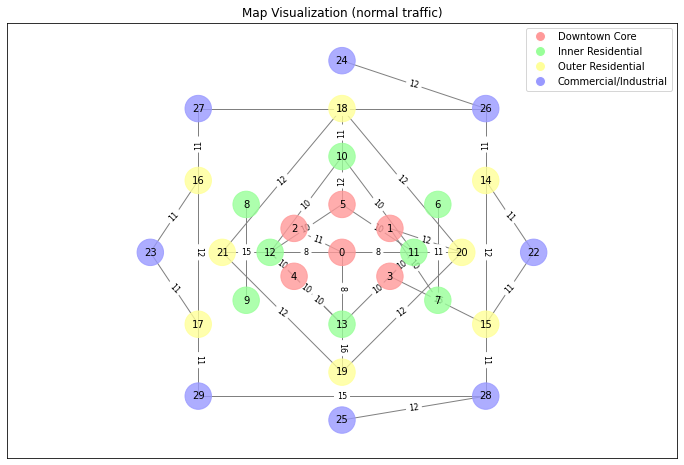


Showing path from downtown (0) to east commercial (11) during normal traffic:


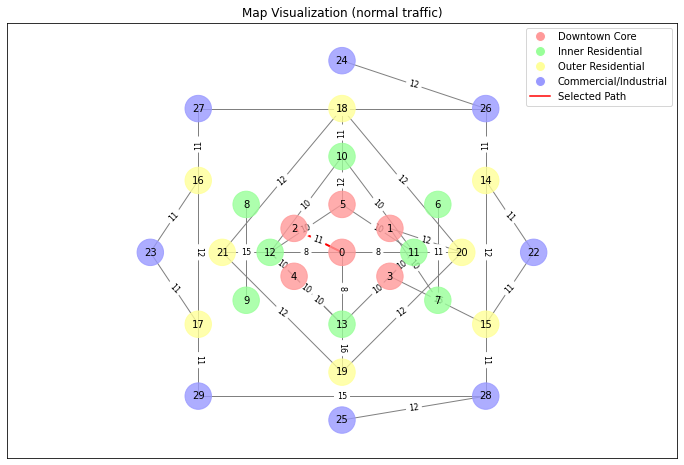

Path: 0 -> 2
From vertex 0 go northwest to vertex 2 (11 minutes)

Total time: 11 minutes

Showing same path during rush hour:


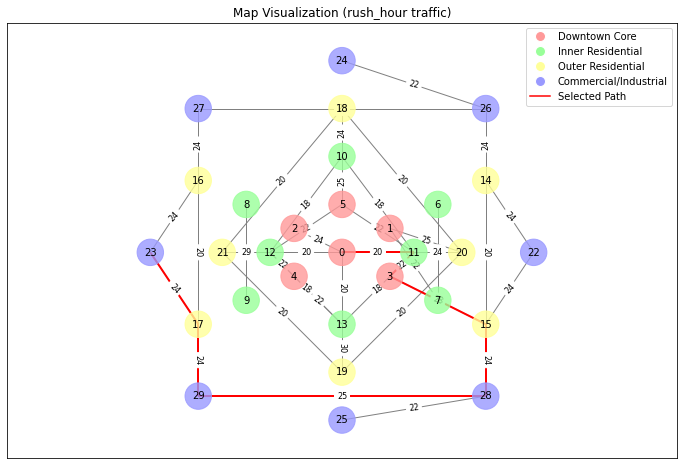

Path: 0 -> 11 -> 3 -> 15 -> 28 -> 29 -> 17 -> 23
From vertex 0 go east to vertex 11 (20 minutes)
From vertex 11 go southwest to vertex 3 (22 minutes)
From vertex 3 go southeast to vertex 15 (28 minutes)
From vertex 15 go south to vertex 28 (24 minutes)
From vertex 28 go west to vertex 29 (25 minutes)
From vertex 29 go north to vertex 17 (24 minutes)
From vertex 17 go northwest to vertex 23 (24 minutes)

Total time: 167 minutes


In [9]:
def demo_visualization():
    # Create the map
    map_graph = create_map()
    
    # Show basic map
    print("Showing basic map:")
    visualize_graph(map_graph, traffic_condition='normal')
    
    # Show a path
    print("\nShowing path from downtown (0) to east commercial (11) during normal traffic:")
    total_time, path = map_graph.dijkstra(0, 2, 'normal')
    visualize_graph(map_graph, path, 'normal')
    print(f"Path: {' -> '.join(map(str, path))}")
    print(map_graph.get_path_description(path, 'normal'))
    
    # Show same path during rush hour
    print("\nShowing same path during rush hour:")
    total_time, path = map_graph.dijkstra(0, 23, 'rush_hour')
    visualize_graph(map_graph, path, 'rush_hour')
    print(f"Path: {' -> '.join(map(str, path))}")
    print(map_graph.get_path_description(path, 'rush_hour'))

if __name__ == "__main__":
    demo_visualization()

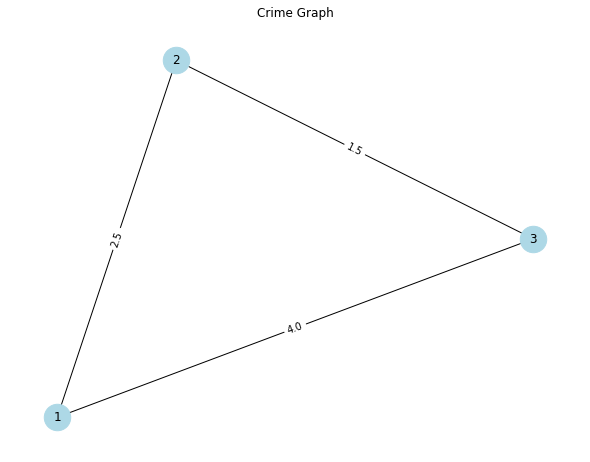

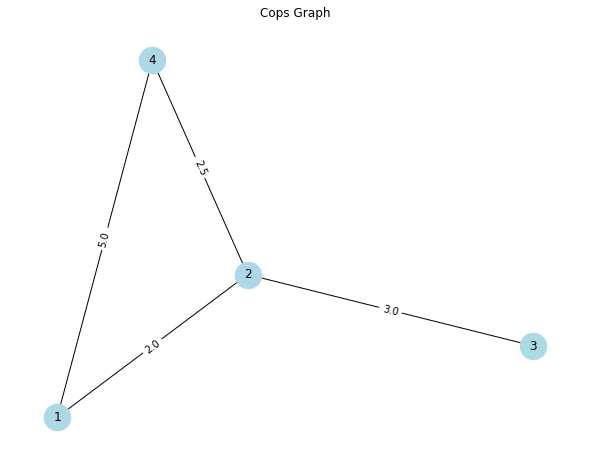

Shortest path in the cops graph from 1 to 3: [1, 2, 3]


In [10]:
import networkx as nx
import matplotlib.pyplot as plt

class Vertex:
    def __init__(self, id, x, y):
        self.id = id
        self.x = x
        self.y = y
        self.edges = {}  # Dictionary of connected vertices and their edges
    
    def __str__(self):
        return f"Vertex {self.id} at ({self.x}, {self.y})"

class Edge:
    def __init__(self, vertex1, vertex2, weight):
        self.vertex1 = vertex1
        self.vertex2 = vertex2
        self.weight = weight

# Function to create a graph
def create_graph(vertices, edges):
    graph = nx.Graph()
    for vertex in vertices:
        graph.add_node(vertex.id, pos=(vertex.x, vertex.y))
    for edge in edges:
        graph.add_edge(edge.vertex1.id, edge.vertex2.id, weight=edge.weight)
    return graph

# Function to find the shortest path using Dijkstra's algorithm
def find_shortest_path(graph, start_id, end_id):
    return nx.dijkstra_path(graph, start_id, end_id, weight='weight')

# Function to visualize a graph
def visualize_graph(graph, title):
    pos = nx.get_node_attributes(graph, 'pos')
    labels = nx.get_edge_attributes(graph, 'weight')
    plt.figure(figsize=(8, 6))
    nx.draw(graph, pos, with_labels=True, node_size=700, node_color="lightblue")
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)
    plt.title(title)
    plt.show()

# Example vertices and edges for both graphs
crime_vertices = [Vertex(1, 0, 0), Vertex(2, 1, 2), Vertex(3, 4, 1)]
crime_edges = [Edge(crime_vertices[0], crime_vertices[1], 2.5), 
               Edge(crime_vertices[1], crime_vertices[2], 1.5),
               Edge(crime_vertices[0], crime_vertices[2], 4.0)]

cops_vertices = [Vertex(1, 0, 0), Vertex(2, 2, 2), Vertex(3, 5, 1), Vertex(4, 1, 5)]
cops_edges = [Edge(cops_vertices[0], cops_vertices[1], 2.0), 
              Edge(cops_vertices[1], cops_vertices[2], 3.0),
              Edge(cops_vertices[1], cops_vertices[3], 2.5),
              Edge(cops_vertices[0], cops_vertices[3], 5.0)]

# Create graphs for crimes and cops
crime_graph = create_graph(crime_vertices, crime_edges)
cops_graph = create_graph(cops_vertices, cops_edges)

# Find the shortest path in the cops graph
start_node = 1
end_node = 3
shortest_path = find_shortest_path(cops_graph, start_node, end_node)

# Visualize both graphs and print the shortest path
visualize_graph(crime_graph, "Crime Graph")
visualize_graph(cops_graph, "Cops Graph")
print(f"Shortest path in the cops graph from {start_node} to {end_node}: {shortest_path}")